# Projeto 3#
#### Antonio Fonseca, Daniel Pucciariello e José Bechara.####

## Tema:##
*Prever se um projeto do kickstarter irá ser bem sucedido ou não.*

Técnica: Classificador.

Objetivo secundário:

*Tentar estimar o valor a ser recebido baseado nas características de um projeto do kickstarter.*

Técnica: Regressão.

https://www.kaggle.com/kemical/kickstarter-projects


In [1]:
%matplotlib notebook
%reset -f


import pandas as pd
import numpy as np
from scipy.stats import norm, probplot
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import preprocessing

from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

from datetime import datetime

%matplotlib inline

In [2]:
def dummify(data, column_name):
    """
        Converte a coluna column_name em dummies / one-hot e as adiciona ao dataframe
        retorna uma copia do  df original *sem* a coluna que foi dummified
    """
    df = data.copy()
    # Nota: se você for um econometrista, pode se interessar por usar a opção dropFirst = True na get_dummies
    df2 = pd.concat([df.drop(column_name, axis=1), pd.get_dummies(data[column_name], prefix=column_name)], axis=1)
    return df2
def calculo_dias(date1,date2):
    """
        Função que calculo a quantidade de dias que um projeto ficou ativo.
    """
    date_format = "%Y-%m-%d %H:%M:%S"
    a = datetime.strptime(date1, date_format)
    b = datetime.strptime(date2, date_format)
    delta= a-b
    return delta.days


### Leitura dos dataframes:

In [3]:
data = pd.read_csv('ks-projects-201801.csv', parse_dates=['deadline', 'launched'])
#Retirando os projetos ainda não finalizados:
data = data[data.state != "live"]

In [4]:
data.main_category.value_counts(True)

Film & Video    0.168288
Music           0.137383
Publishing      0.105291
Games           0.092970
Technology      0.085648
Design          0.079191
Art             0.074386
Food            0.064965
Fashion         0.060038
Theater         0.028926
Comics          0.028582
Photography     0.028550
Crafts          0.023235
Journalism      0.012568
Dance           0.009977
Name: main_category, dtype: float64

In [5]:
data.head(3)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00


In [6]:
print("Tamanho do dataframe:")
len(data)

Tamanho do dataframe:


375862

In [7]:
data.category = data.category.astype('category')
data.main_category = data.main_category.astype('category')
data.state = data.state.astype('category')
data.country = data.country.astype('category')

### Porcentagem de sucesso nos projetos:

In [8]:
data.state.value_counts(True)*100

failed        52.604147
successful    35.639676
canceled      10.317351
undefined      0.947688
suspended      0.491138
Name: state, dtype: float64

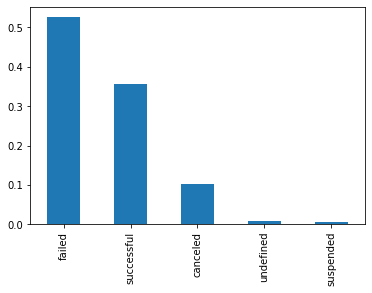

In [9]:
data.state.value_counts(True).plot.bar();

# Regressão Logística:

### "Dummyficando" as variáveis qualitativas:

In [10]:
data_dummified = dummify(data, "state")

data_dummified.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'backers', 'country', 'usd pledged',
       'usd_pledged_real', 'usd_goal_real', 'state_canceled', 'state_failed',
       'state_successful', 'state_suspended', 'state_undefined'],
      dtype='object')

In [11]:
Y1 = data_dummified.loc[:,["state_canceled", "state_failed","state_successful","state_suspended", "state_undefined"]]
y= Y1.state_successful == 1 
X1 = data_dummified.loc[:,['goal']]

In [31]:
from sklearn.model_selection import train_test_split
X_train_, X_test_, y_train_, y_test_ = train_test_split(X1, y, test_size=0.1, random_state=112)

In [32]:
X_train_.shape, y_train_.shape, X_test_.shape, y_test_.shape

((338275, 1), (338275,), (37587, 1), (37587,))

In [36]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', multi_class='auto',max_iter=200)

In [37]:
model.fit(X_train_, y_train_)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [38]:
y_pred = model.predict(X_test_)

# Calcula acurácia.
acc = accuracy_score(y_test_, y_pred)

print('Acurácia: {}'.format(acc))

Acurácia: 0.6482826509165402


In [20]:
data_dummified = dummify(data, "main_category")
data_dummified = dummify(data_dummified, "state")

data_dummified.columns

#criação de um dataframe com as variaveis quantitativas (incluindo as provenientes de dummyficação)
quantitativas = data_dummified.loc[:,['goal', 'state_successful', 'main_category_Art', 'main_category_Comics',
       'main_category_Crafts', 'main_category_Dance', 'main_category_Design',
       'main_category_Fashion', 'main_category_Film & Video',
       'main_category_Food', 'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater' ]]
quantitativas.head(5)

,goal,state_successful,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
0,1000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,30000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,45000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,5000.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,19500.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


### Calculando o tempo de duração da campanha:

In [21]:
#criação de uma lista com os valores de tempo de campanha em dias.
delta_t =[]
for e,i in zip(data.deadline, data.launched):
    e = str(e)
    i = str(i)
    a = calculo_dias(e,i)
    delta_t.append(a)

In [22]:
#criação de um dataframe semelhante ao criado anteriormente, porém com o delta_t dos projetos.
data_delta_t=quantitativas
data_delta_t["deltat (days)"]=delta_t
data_delta_t.head()

,goal,state_successful,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater,deltat (days)
0,1000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,58
1,30000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,59
2,45000.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,44
3,5000.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,29
4,19500.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,55


In [23]:
y = quantitativas.state_successful == 1 # Selecionando apenas as campanhas que obtiveram sucesso para criar uma lista com valores booleanos (True ou False)

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_delta_t, y, test_size=0.1, random_state=112)

In [25]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((338275, 18), (338275,), (37587, 18), (37587,))

In [26]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', multi_class='auto',max_iter=200)

In [27]:
X_train=X_train.drop(columns=['state_successful']) # removendo coluna de estado do dataframe de treinamento

In [28]:
X_test=X_test.drop(columns=['state_successful'])# removendo coluna de estado do dataframe de teste 

In [29]:
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
y_pred = model.predict(X_test)

# Calcula acurácia.
acc = accuracy_score(y_test, y_pred)

print('Acurácia: {}'.format(acc))

Acurácia: 0.6482826509165402


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rdm_forest = RandomForestClassifier(n_estimators=10, random_state=112)
rdm_forest = rdm_forest.fit(X_train,y_train)
rdm_forest

In [ ]:
y_pred = rdm_forest.predict(X_test)

# Calcula acurácia.
acc = accuracy_score(y_test, y_pred)

print('Acurácia: {}'.format(acc))

# Regressão Linear:

In [ ]:
def regress(X,Y):
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    return results

def rms(y, y_pred):
    '''
    Retorna o RMS
    
    y --> valores reais
    y_pred --> valores preditos
    '''
    return (sum((y-y_pred)**2)*1/len(y))**0.5

def acuracia(limite, y_pred, y_test):
    total = 0
    acertos = 0
    erros = 0
    lista = []
    for e,i in zip(y_pred, y_test):
        total+=1
        maximo = i + limite*i 
        minimo = i - limite*i
        if e<=maximo and e>=minimo:
            lista.append(True)
            acertos +=1
        else:
            lista.append(False)
            erros+=1
    acc = "Acurácia=",acertos/total
    erro = "Erro=",erros/total
    
    return acc, erro

In [ ]:
Y2 = data_dummified.usd_pledged_real

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X1, Y2, test_size=0.1, random_state=112)

In [ ]:
model = regress(X_train2,y_train2)
model.summary() 

In [ ]:
x_vc=(sm.add_constant(X_test2))
y_pred2=model.predict(x_vc) 
erro = rms(y_test2,y_pred2)
print("RMS =",erro)

In [ ]:
acc = acuracia(0.35, y_pred2, y_test2)
acc

## Random Forest regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [ ]:
regr_rd = RandomForestRegressor(max_depth=4, random_state=113, n_estimators=100) 
regr_rd.fit(X_train2, y_train2)  

y_pred3=regr_rd.predict(X_test2)

In [ ]:
from sklearn.metrics import r2_score

r2_score(y_test2, y_pred3, multioutput="variance_weighted")

In [ ]:
acc = acuracia(0.35, y_pred3, y_test2)
acc